In [1]:
# import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import warnings as datawarnings
datawarnings.filterwarnings('ignore')
        

# Data cleanzing
**The dataset is clean, with no missing data. All variables are continuous numerical and do not necessitate normalization. Outlier detection and handling will be the next step**


In [3]:
df = pd.read_pickle('df_prep.pkl')
con_df = df.drop(columns=['diagnosis',"id"])
skewness_values = con_df.skew()

# Outlier detection and handling

In [5]:

def boxplot(con_df):
    for i, col in enumerate(con_df.columns):
            ax = plt.subplot(60, 3, i+1)
            sb.boxplot(data=con_df, x=col, ax=ax)
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Box Plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)

In [6]:

def scatterplot(con_df):
    for i, col in enumerate(con_df.columns):
            ax = plt.subplot(60, 3, i+1)
            sb.scatterplot(x=con_df.index,y=con_df[col])
            plt.subplots_adjust(hspace = 0.7)
            plt.title('Scatter plot: {}'.format(col), fontsize=15)
            plt.xlabel('{}'.format(col), fontsize=14)
        

## Outliers for parametric distribution
### The code identifies columns with near-normal (parametric) distributions and then creates boxplots and scatterplots to visualize these distributions and detect outliers.

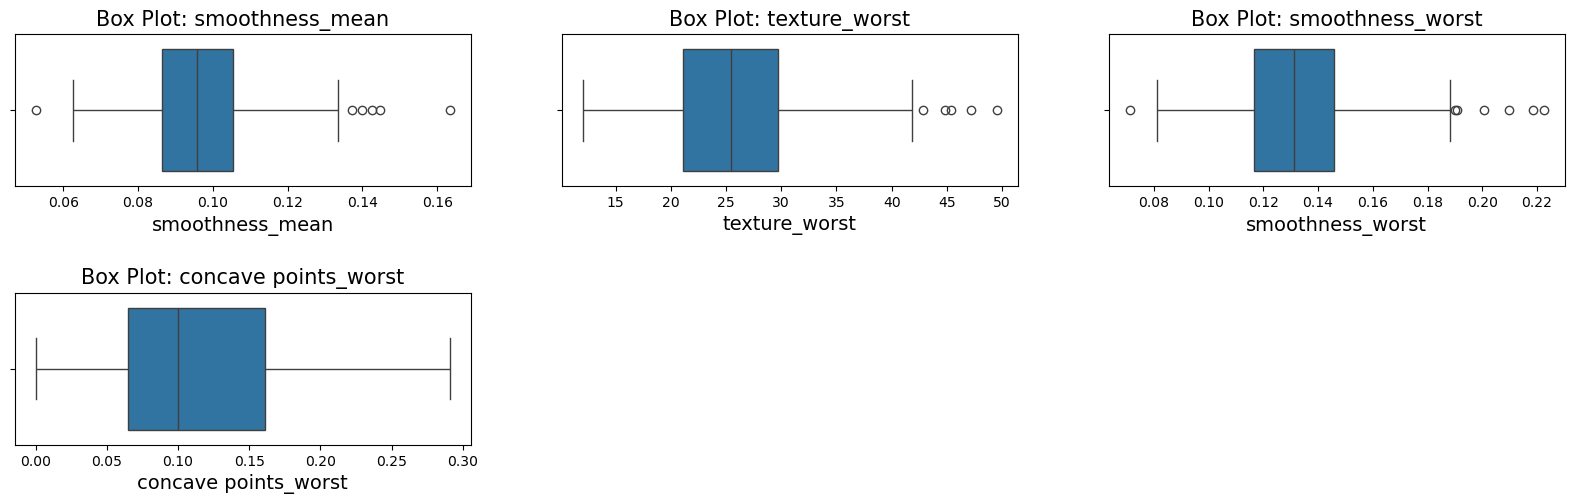

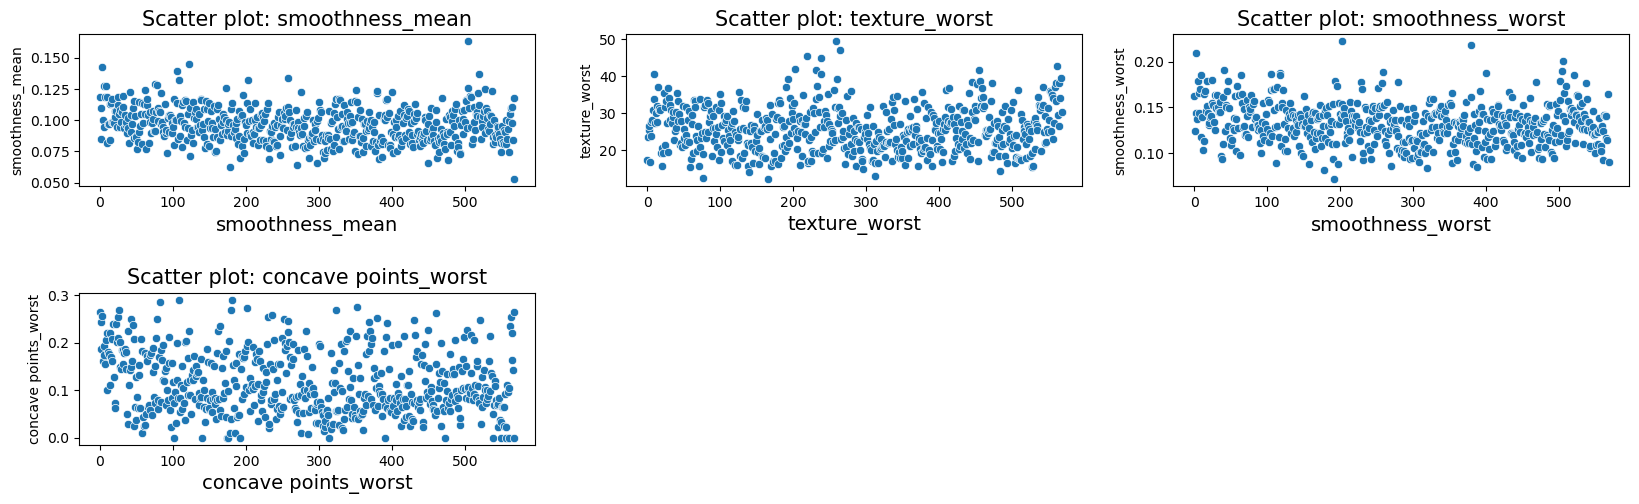

In [8]:
# outliers for parametric distribution
para_columns = skewness_values[abs(skewness_values) <= 0.5].index.tolist()
plt.figure(figsize=(20,200))
boxplot(df[para_columns])

plt.figure(figsize=(20,200))
scatterplot(df[para_columns])

### This code identify and optionally remove outliers from a dataset using the Z-score method, specifically for columns that follow a parametric distribution. 

In [10]:
#  outliers
# identify outliers using z-score for parametric distribution
from scipy import stats
from scipy.stats import zscore

threshold = 2.5
for col in para_columns:
    z = np.abs(stats.zscore(df[col]))
    df2 = df.copy()
    df2 = df2[z < threshold]
    num_of_outliers = df[col].count() - df2[col].count()
    if  num_of_outliers > 0:
        percent_num_of_outliers = (num_of_outliers/df[col].count())*100
        p_value = stats.ks_2samp(df[col], df2[col])[1]
        correlation = df[col].corr(df['diagnosis'])
        correlation2 = df2[col].corr(df2['diagnosis'])
        correlation_diff = abs(correlation - correlation2)
        # corollation is the same, distribution changed, 
        remove_outlier =  (correlation_diff < 0.05) & (p_value < 0.05)
        if remove_outlier:
            df[col][z > threshold] = np.nan
        print(f"col: {col}, num of outliers: {num_of_outliers}, Percentage of outliers: {percent_num_of_outliers} %")
        print(f"p_value: {p_value}")
        print(f"original correlation: {correlation}, correlation after removing outliers: {correlation2},correlation changing: {correlation_diff}") 
        print(f"fill nan instaed of outlier: {remove_outlier}\n\n")
        


col: smoothness_mean, num of outliers: 9, Percentage of outliers: 1.5817223198594026 %
p_value: 0.9999999738114437
original correlation: 0.3585599650859315, correlation after removing outliers: 0.35867215267158675,correlation changing: 0.00011218758565523235
fill nan instaed of outlier: False


col: texture_worst, num of outliers: 8, Percentage of outliers: 1.4059753954305798 %
p_value: 0.999999973163413
original correlation: 0.4569028213967977, correlation after removing outliers: 0.45597500573446315,correlation changing: 0.0009278156623345746
fill nan instaed of outlier: False


col: smoothness_worst, num of outliers: 7, Percentage of outliers: 1.2302284710017575 %
p_value: 0.9999999999999739
original correlation: 0.4214648610664021, correlation after removing outliers: 0.42430511132383275,correlation changing: 0.0028402502574306765
fill nan instaed of outlier: False


col: concave points_worst, num of outliers: 3, Percentage of outliers: 0.5272407732864675 %
p_value: 1.0
original co

### Conclusion:
For all the columns analyzed (smoothness_mean, texture_worst, smoothness_worst, and concave_points_worst), the decision was made not to remove the outliers because they do not significantly affect the distribution or the correlation with the target variable.

## Outliers for nonparametric distribution
### The code identifies columns with skewed (non-parametric) distributions and then creates boxplots and scatterplots to visualize these distributions and detect outliers. 

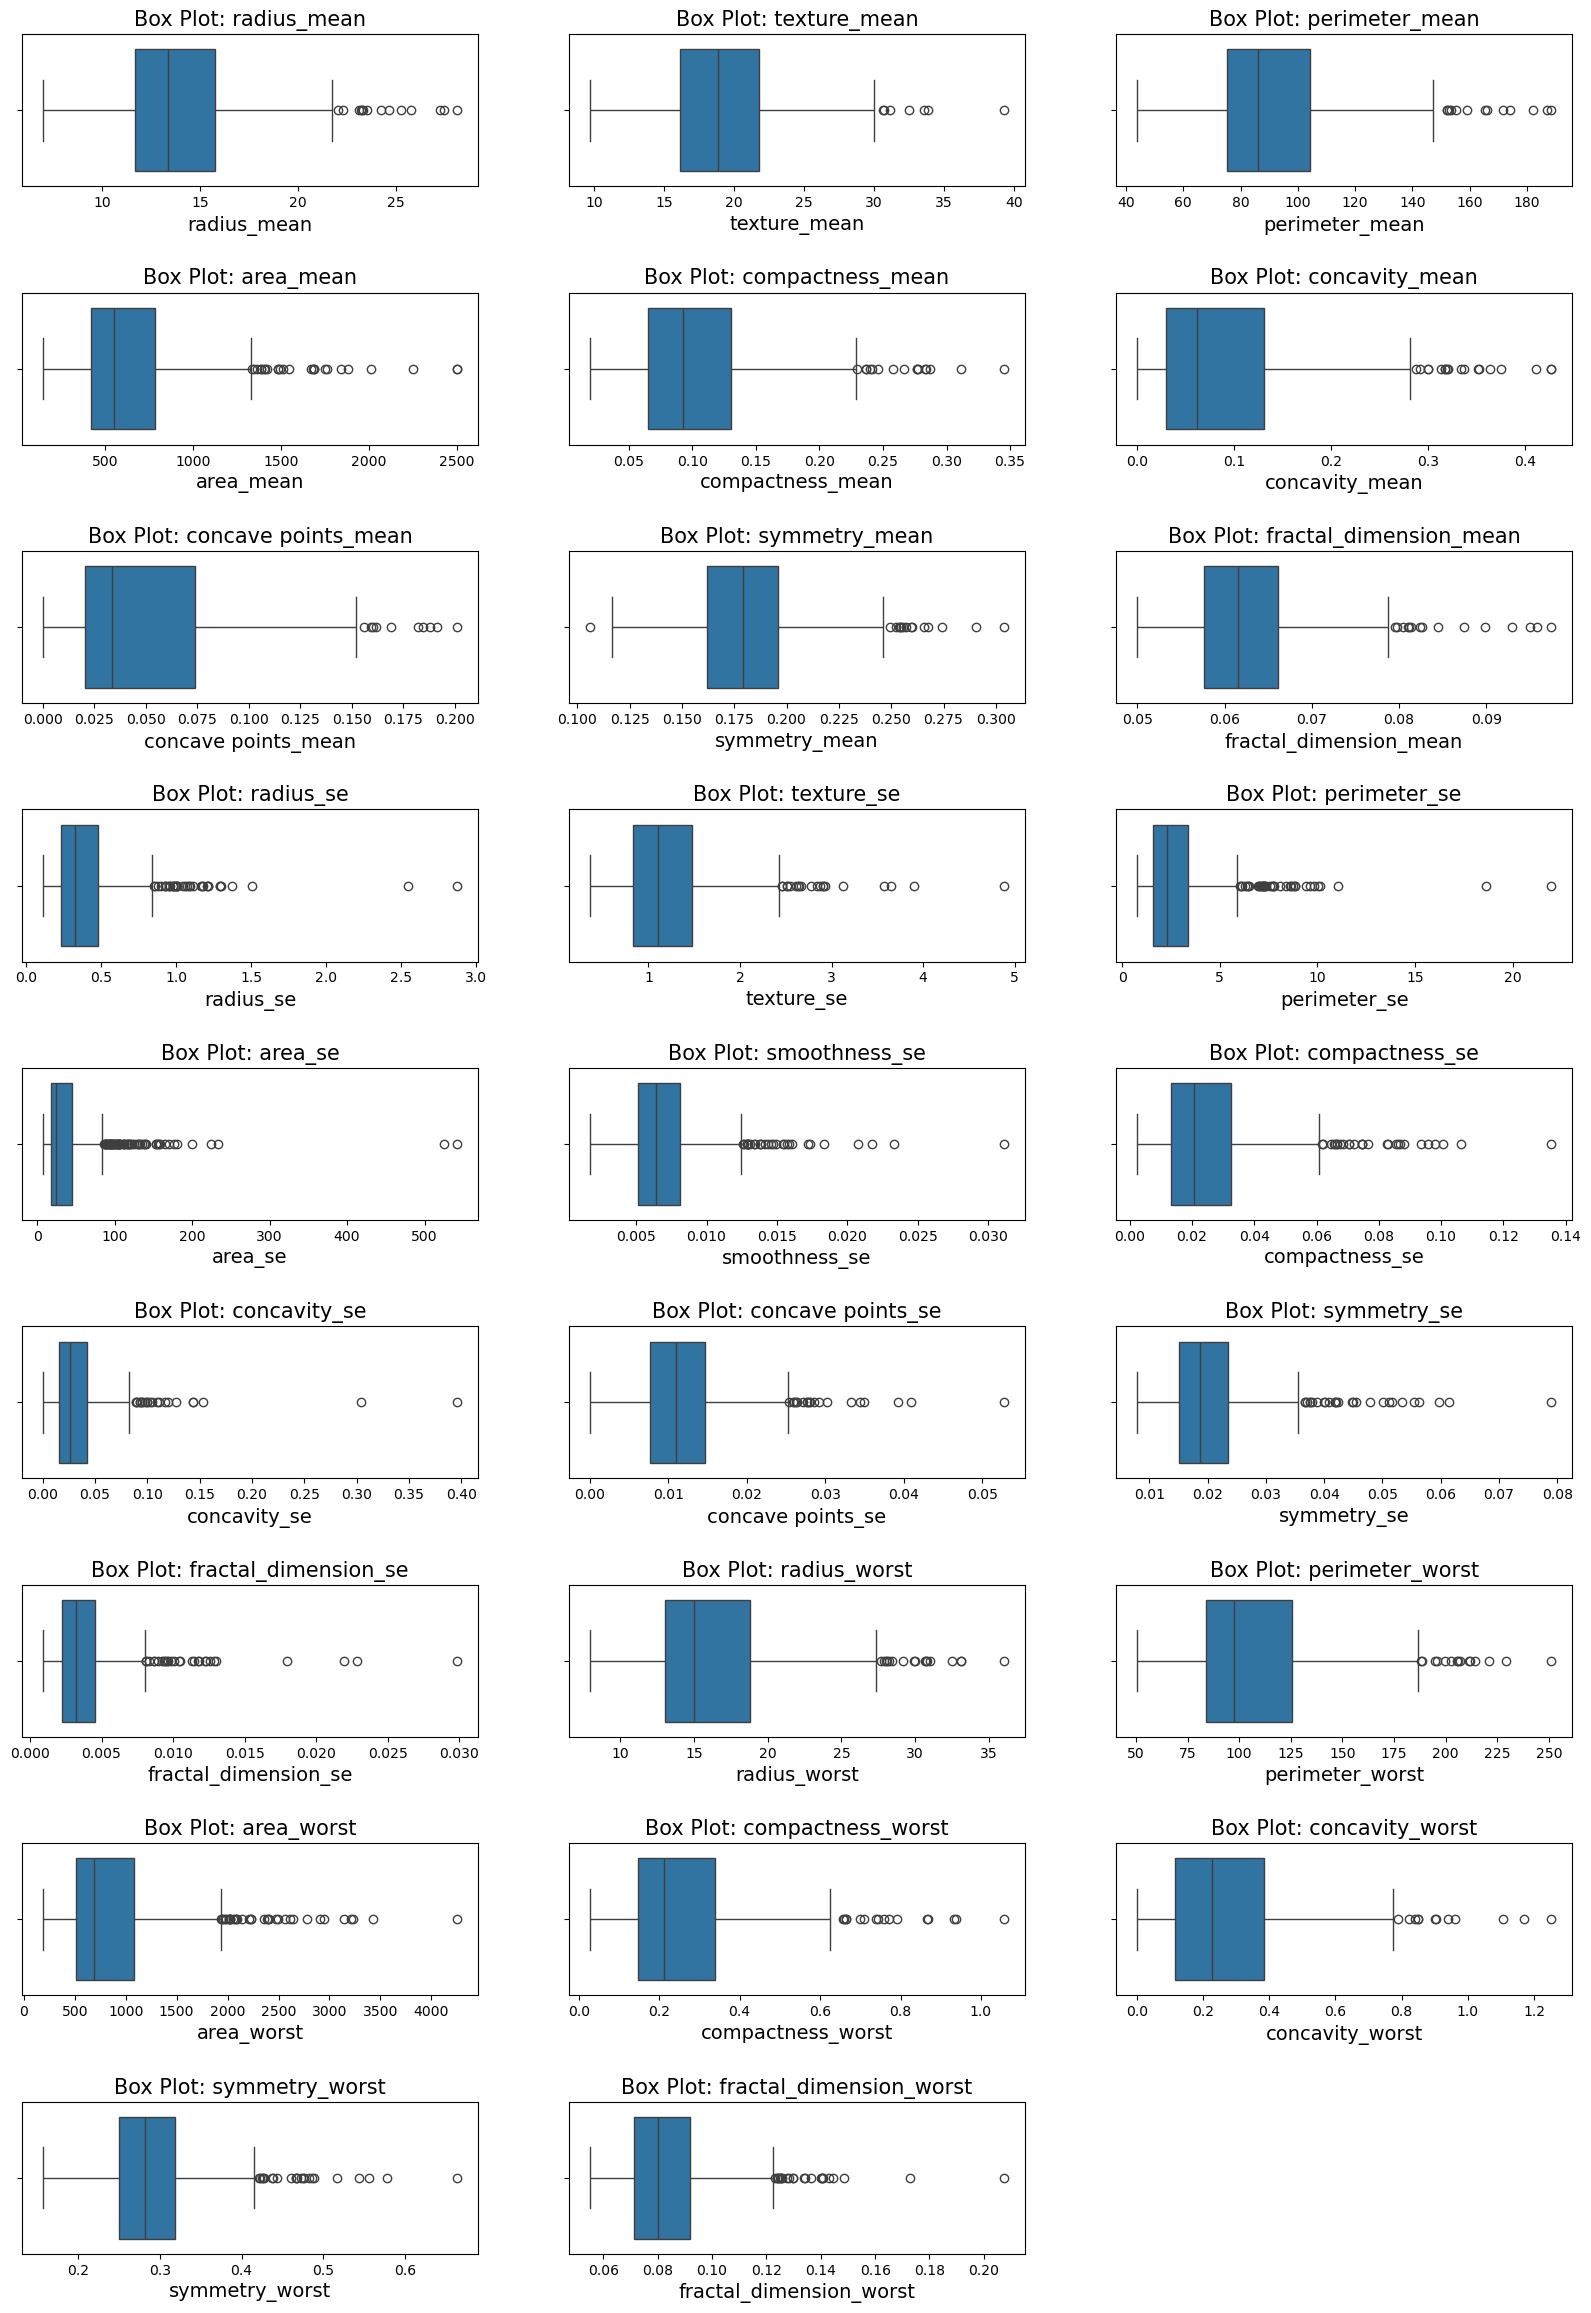

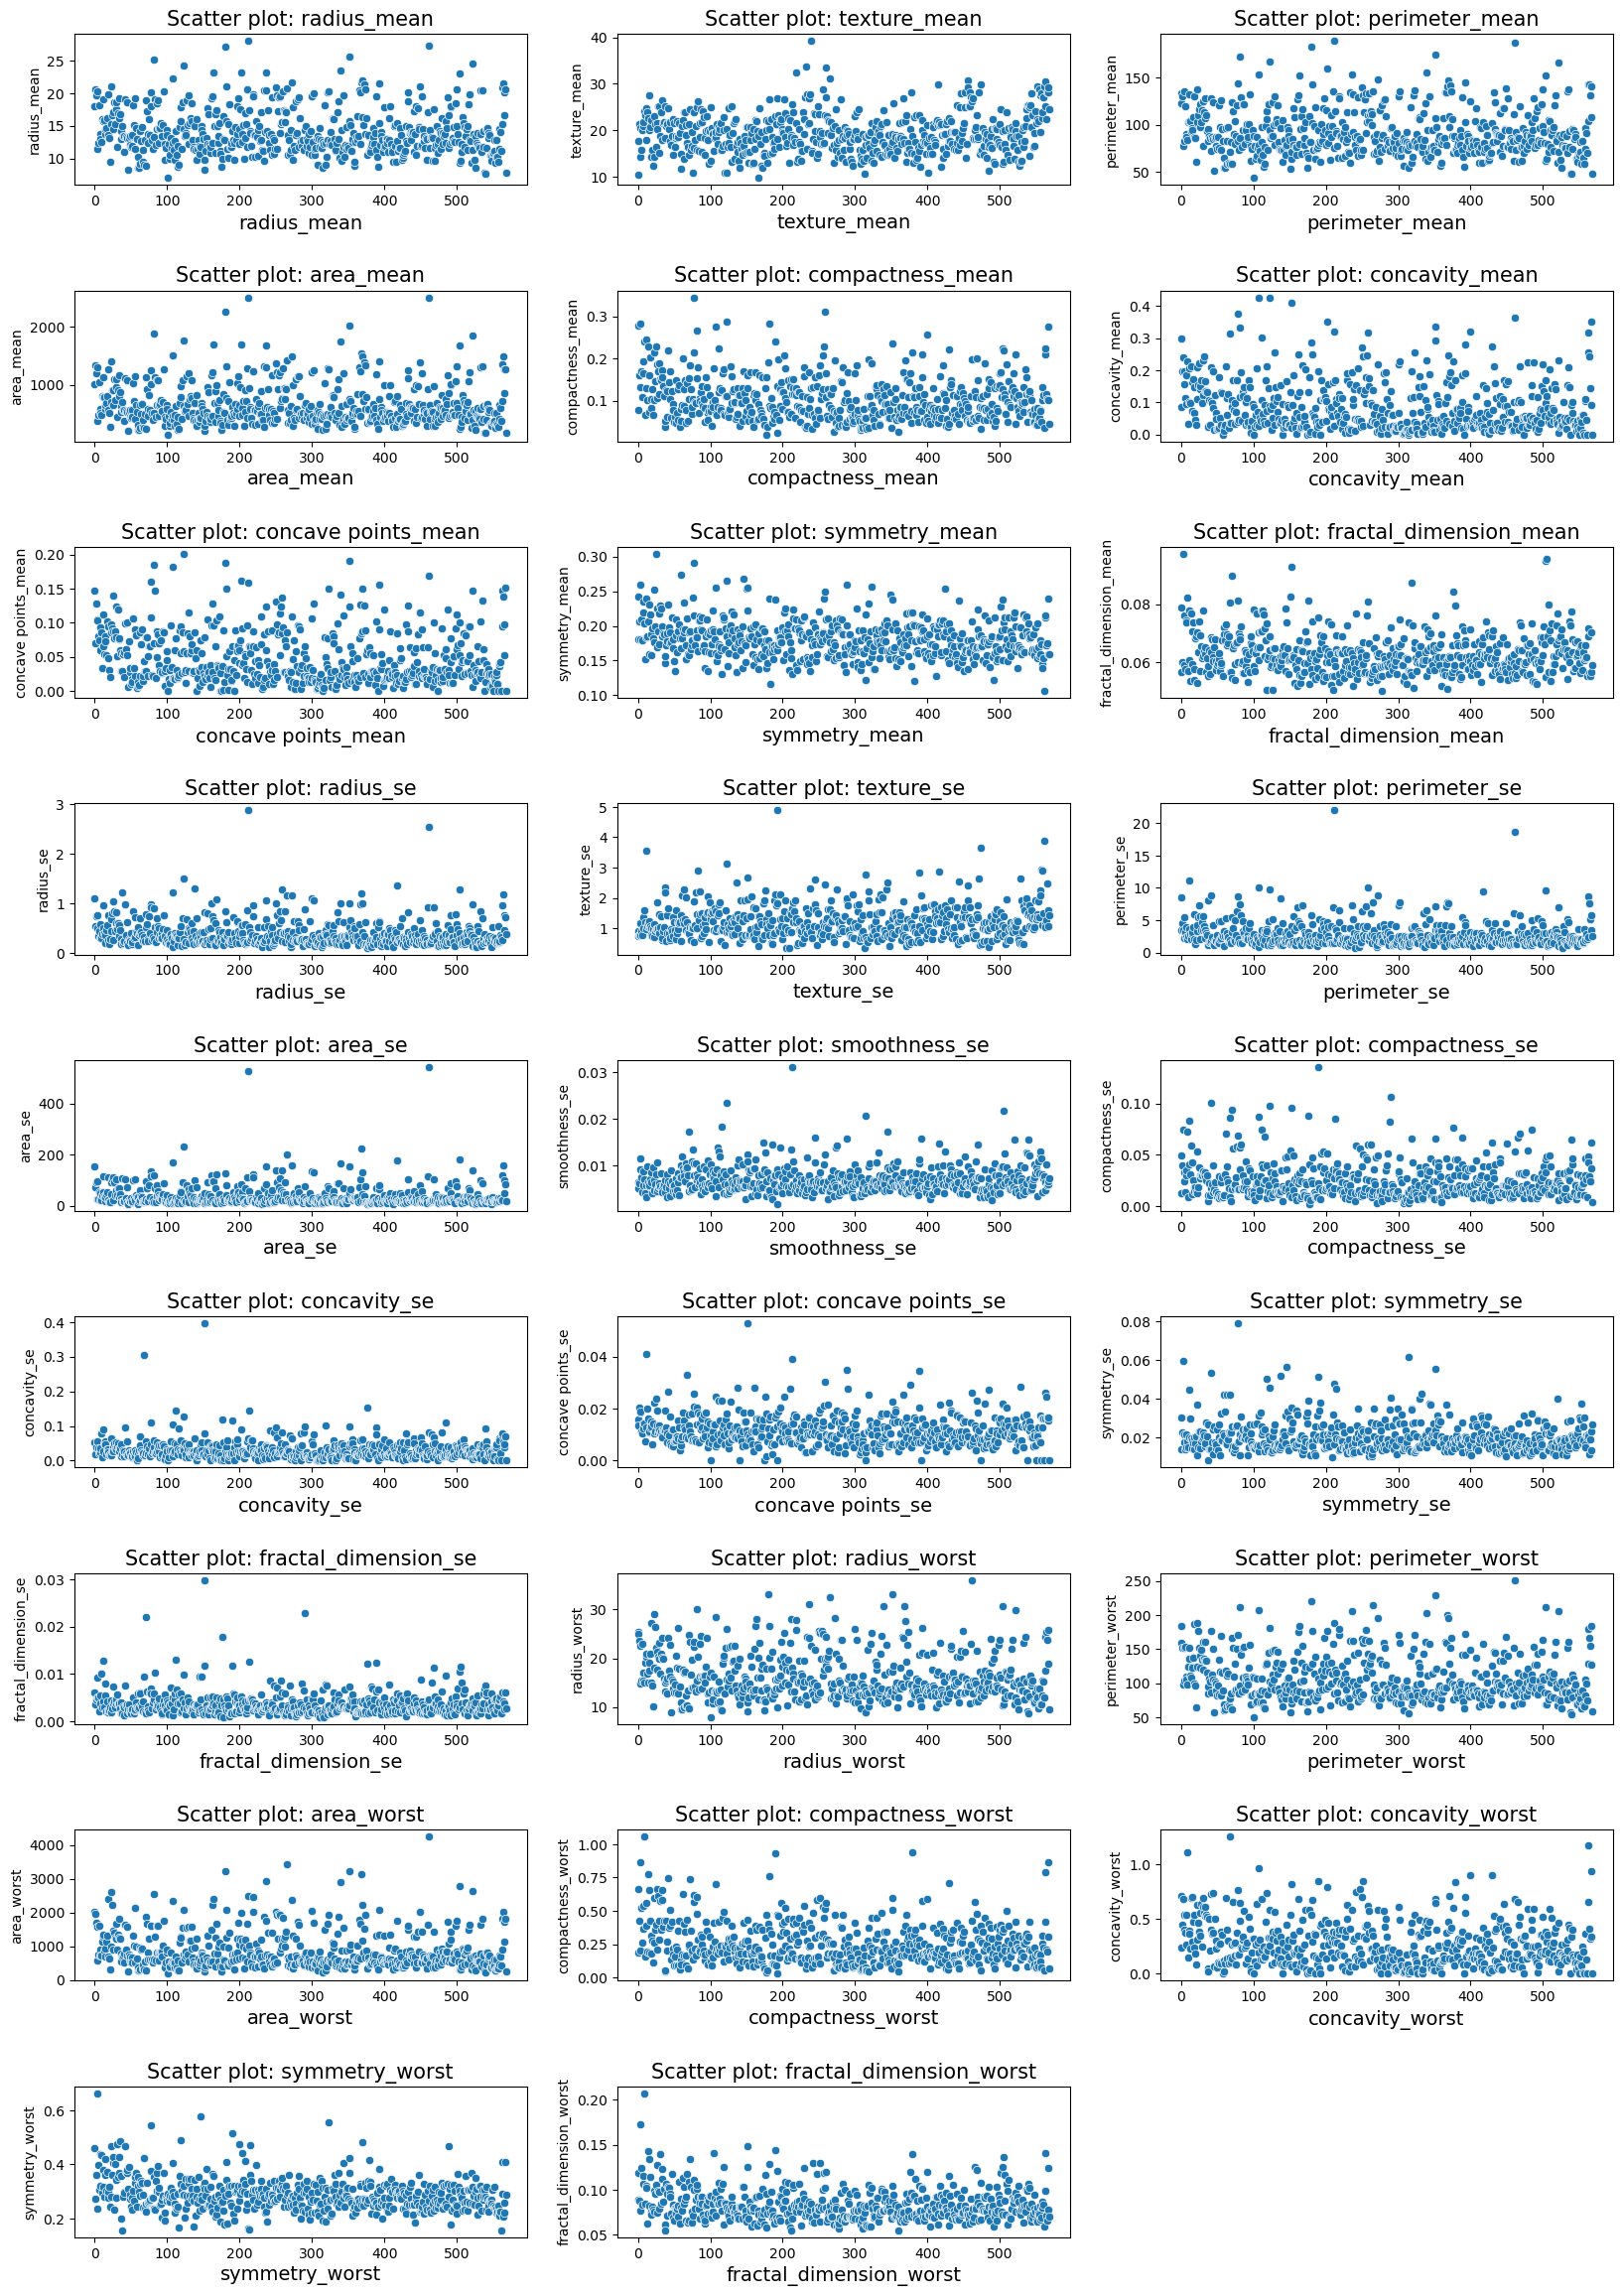

In [13]:
#  outliers for nonparametric distribution
notpara_columns = skewness_values[abs(skewness_values) > 0.5].index.tolist()
plt.figure(figsize=(20,200))
boxplot(df[notpara_columns])

plt.figure(figsize=(20,200))
scatterplot(df[notpara_columns])

In [14]:
def treat_outliers(df, features):
    df_outliers = pd.DataFrame(index=df.index)
    for feature in features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_outliers[feature] = ((df[feature] < lower_bound) | (df[feature] > upper_bound)).astype(int)
    return df_outliers



### This code identifies outliers using the Interquartile Range (IQR) method for non-parametric columns in a dataset. 


In [16]:
# identify outliers using IQR 
outliers_df = treat_outliers(df, notpara_columns)
for col in notpara_columns:
    df2 = df[(outliers_df[col] == 0)]
    num_of_outliers = df[col].count() - df2[col].count()
    if  num_of_outliers > 0:
        percent_num_of_outliers = (num_of_outliers/df[col].count())* 100
        p_value = stats.ks_2samp(df[col], df2[col])[1]
        correlation = df[col].corr(df['diagnosis'],method="spearman")
        correlation2 = df2[col].corr(df2['diagnosis'],method="spearman")
        correlation_diff = abs(correlation - correlation2)
        # corollation is the same, distribution changed 
        remove_outlier =  (correlation_diff < 0.05) & (p_value < 0.05)
        if remove_outlier:
            print("hi")
            df[col][(outliers_df[col] == 1)] = np.nan
        print(f"col: {col}, num of outliers: {num_of_outliers}, Percentage of outliers: {percent_num_of_outliers} %")
        print(f"p_value: {p_value}")
        print(f"original correlation: {correlation}, correlation after removing outliers: {correlation2},correlation changing: {correlation_diff}") 
        print(f"fill nan instaed of outlier: {remove_outlier}\n\n")

col: radius_mean, num of outliers: 14, Percentage of outliers: 2.460456942003515 %
p_value: 0.9934323936117693
original correlation: 0.7327849896210553, correlation after removing outliers: 0.7187086097357105,correlation changing: 0.014076379885344825
fill nan instaed of outlier: False


col: texture_mean, num of outliers: 7, Percentage of outliers: 1.2302284710017575 %
p_value: 0.9999999998904686
original correlation: 0.4619709203699609, correlation after removing outliers: 0.4591983257522409,correlation changing: 0.0027725946177200034
fill nan instaed of outlier: False


col: perimeter_mean, num of outliers: 13, Percentage of outliers: 2.2847100175746924 %
p_value: 0.9975048738106226
original correlation: 0.7484960094161621, correlation after removing outliers: 0.7363788426393386,correlation changing: 0.012117166776823507
fill nan instaed of outlier: False


col: area_mean, num of outliers: 25, Percentage of outliers: 4.393673110720562 %
p_value: 0.6334749769689041
original correlati

### Conclusion:
### Minimal Impact of Outliers: The analysis indicates that outliers have a minimal impact on the correlations between features and the target variable, as well as on the overall distributions. Therefore, it was decided not to remove them.
### Model Robustness: This suggests that your model may be robust to the presence of these outliers, or that the outliers themselves might represent valuable variations in the data that are worth keeping.

In [18]:
# check for null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    int8   
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [19]:
df.to_pickle('df_cleaned.pkl')
